# DES Simulation

This notebook generates the results used in the report for the second assignment of the course 'Stochastic Simulation'.

Authors:

1. Divyaben Hasmukhbhai Gajera
- Affiliation: MSc Computational Science, University of Amsterdam
- Email: divya.gajera@student.uva.nl
- Student Number: 14932644

2. K. López
- Affiliation: MSc Computational Science, University of Amsterdam
- Email: kenia.lopez.sotomayor@student.uva.nl
- Student Number: 12965081

3. T. P. Glansdorp
- Affiliation: MSc Computational Science, University of Amsterdam
- Email: thomas.glansdorp@student.uva.nl
- Student Number: 12748587

## DES program that implements FIFO scheduling case

In [130]:
import simpy as sm
import random
import pandas as pd
import csv
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import matplotlib.pyplot as plt

In [131]:
class g:
    arrival_rate = 1
    service_rate = 2
    number_of_servers = 1
    sim_duration = 200
    number_of_runs = 100

class Customer:
    def __init__(self, customer_id):
        self.id = customer_id
        self.queue_time = 0

class Queue:
    
    def __init__(self, run_number, queue_type):
        self.env = sm.Environment()
        self.server = sm.Resource(self.env, capacity=g.number_of_servers)
        self.queue_type = queue_type
        self.customer_counter = 0
        self.mean_queue_time = 0
        self.mean_sojourn_time = 0
        columns = ["Customer ID", "Start Queueing", "End Queueing", "Queueing Time", "Sojourn Time"] 
        self.results_df = pd.DataFrame(columns=columns)
        self.results_df.set_index("Customer ID", inplace=True)
        self.arrival_times = []
        self.departure_times = []
        
    
    # Method that generates customers arrivals
    def generate_arrivals(self):
        while True:
            self.customer_counter += 1
            cp = Customer(self.customer_counter)
            # Run activity generator for this customer
            self.env.process(self.create_queue(cp))

            # sample time until next customer
            t = random.expovariate(g.arrival_rate)

            # Freeze untill that time has passed
            yield self.env.timeout(t)
            
    def create_queue(self, customer):
        start_queue = self.env.now
        self.arrival_times.append(self.env.now)
        
        # Request a server
        with self.server.request() as req:
            # Freeze until the request can be met 
            yield req
            
            # Sample time spent in server
            if self.queue_type == "MMn":
                sampled_service_time = random.expovariate(g.service_rate)
            elif self.queue_type == "MDn":
                sampled_service_time = 0.5
            elif self.queue_type == "MLn":
                    rand = random.random()
                    if rand <= 0.75:
                        sampled_service_time = random.expovariate(1.0)
                    else:
                        sampled_service_time = random.expovariate(5.0)
            
            end_queue = self.env.now
            
            # Freeze until that time has passed
            yield self.env.timeout(sampled_service_time)
            self.departure_times.append(self.env.now)
            
            # Calculate time customer was queueing
            out_of_system = self.env.now
            sojourn_time = out_of_system - start_queue
            customer.queue_time = end_queue - start_queue
            
            df_to_add = [start_queue, end_queue, customer.queue_time, sojourn_time]
            self.results_df.loc[customer.id] = df_to_add
            
    def calculate_mean_times(self):
        self.mean_queue_time = self.results_df["Queueing Time"].mean()
        self.mean_sojourn_time = self.results_df["Sojourn Time"].mean()
            
    def run(self):
        self.env.process(self.generate_arrivals())
        self.env.run(until=g.sim_duration)
        # Calculate run results
        self.calculate_mean_times()
        

### Shortest Job First

In [134]:
class SJF_queue:
    
    def __init__(self):
        self.env = sm.Environment()
        self.server = sm.PriorityResource(self.env, capacity=g.number_of_servers)
        self.customer_counter = 0
        self.mean_queue_time = 0
        self.mean_sojourn_time = 0
        columns = ["Customer ID", "Start Queueing", "End Queueing", "Queueing Time", "Sojourn Time"] 
        self.results_df = pd.DataFrame(columns=columns)
        self.results_df.set_index("Customer ID", inplace=True)
        
    
    # Method that generates customers arrivals
    def generate_arrivals(self):
        while True:
            self.customer_counter += 1
            cp = Customer(self.customer_counter)
            # Run activity generator for this customer
            self.env.process(self.create_queue(cp))

            # sample time until next customer
            t = random.expovariate(g.arrival_rate)

            # Freezr untill that time has passed
            yield self.env.timeout(t)
            
    def create_queue(self, customer):
        start_queue = self.env.now
        # Request a server
        sampled_service_time = random.expovariate(g.service_rate)
        with self.server.request(priority = (sampled_service_time)) as req:
            # Freeze until the request can be met 
            yield req  
            
            end_queue = self.env.now

            # Freeze until that time has passed
            yield self.env.timeout(sampled_service_time)
            
            # Calculate time customer was queueing
            out_of_system = self.env.now
            sojourn_time = out_of_system - start_queue
            customer.queue_time = end_queue - start_queue
            df_to_add = [start_queue, end_queue, customer.queue_time, sojourn_time]
            self.results_df.loc[customer.id] = df_to_add
            
    def calculate_mean_queue_time(self):
        self.mean_queue_time = self.results_df["Queueing Time"].mean()
        self.mean_sojourn_time = self.results_df["Sojourn Time"].mean()
        
    def run(self):
        self.env.process(self.generate_arrivals())
        self.env.run(until=g.sim_duration)
        # Calculate run results
        self.calculate_mean_queue_time()
        #self.write_run_results() 

In [161]:
def estimate_waiting_times(type_queue, RHO, n, sim_dura):
    
    MU = 1
    mean_queue = []
    mean_sojourn = []
    
    for rho in RHO:
        temp_mean_queue_run = []
        temp_sj = []
        g.arrival_rate = MU*rho
        g.service_rate = MU
        g.number_of_servers = n
        g.number_of_runs = 100
        g.sim_duration = sim_dura
        for run in range(g.number_of_runs):
            if type_queue == "SJF":
                queue_model = SJF_queue()
            else:
                queue_model = Queue(run, type_queue)
            queue_model.run()
            temp_mean_queue_run.append(queue_model.mean_queue_time)
            temp_sj.append(queue_model.mean_sojourn_time)
        mean_queue.append(np.array(temp_mean_queue_run).mean(axis=0))
        mean_sojourn.append(np.array(temp_sj).mean(axis = 0))
        
    return mean_queue, mean_sojourn

### Analysis 

In [135]:
RHO = [0.1, 0.2, 0.3, 0.4, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]

In [136]:
est_mean_MMn1, est_sojourn_MMn1 = estimate_waiting_times("MMn", RHO, 1, 300)
est_mean_MMn2, est_sojourn_MMn2 = estimate_waiting_times("MMn", RHO, 2, 300)
est_mean_MMn4, est_sojourn_MMn4 = estimate_waiting_times("MMn", RHO, 4, 300)

In [137]:
est_mean_MDn1, est_sojourn_MDn1 = estimate_waiting_times("MDn", RHO, 1, 300)
est_mean_MDn2, est_sojourn_MDn2 = estimate_waiting_times("MDn", RHO, 2, 300)
est_mean_MDn4, est_sojourn_MDn4 = estimate_waiting_times("MDn", RHO, 4, 300)

In [138]:
est_mean_MLn1, est_sojourn_MLn1 = estimate_waiting_times("MLn", RHO, 1, 300)
est_mean_MLn2, est_sojourn_MLn2 = estimate_waiting_times("MLn", RHO, 2, 300)
est_mean_MLn4, est_sojourn_MLn4 = estimate_waiting_times("MLn", RHO, 4, 300)

In [139]:
est_mean_SJF_1, est_sojourn_SJF_1 = estimate_waiting_times("SJF", RHO, 1, 300)
est_mean_SJF_2, est_sojourn_SJF_2 = estimate_waiting_times("SJF", RHO, 2, 300)
est_mean_SJF_4, est_sojourn_SJF_4 = estimate_waiting_times("SJF", RHO, 4, 300)

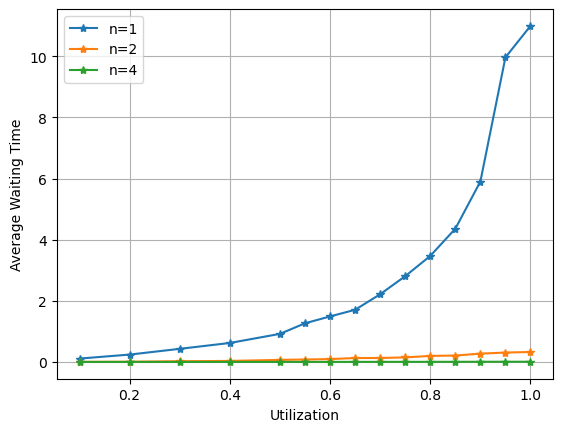

In [140]:
plt.plot(RHO, est_mean_MMn1, "*-", label = "n=1")
plt.plot(RHO, est_mean_MMn2, "*-", label = "n=2")
plt.plot(RHO, est_mean_MMn4, "*-", label = "n=4")
plt.xlabel("Utilization", fontsize = 10)
plt.ylabel("Average Waiting Time", fontsize= 10)
plt.legend()
plt.grid(True)
plt.savefig("W_Vs_Rho_MMn.jpeg")
plt.savefig("W_Vs_Rho_MMn.svg")

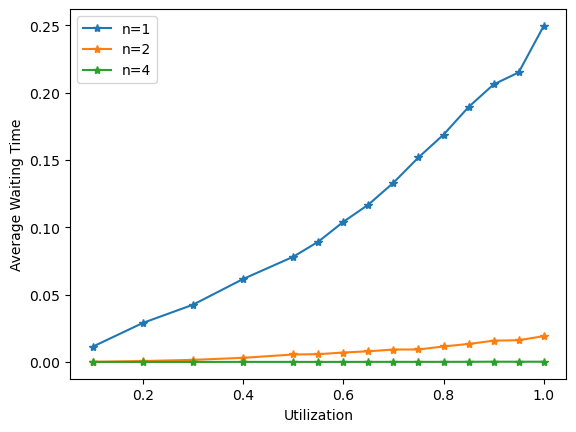

In [141]:
plt.plot(RHO, est_mean_MDn1, "*-", label = "n=1")
plt.plot(RHO, est_mean_MDn2, "*-", label = "n=2")
plt.plot(RHO, est_mean_MDn4, "*-", label = "n=4")
plt.legend()
plt.xlabel("Utilization", fontsize = 10)
plt.ylabel("Average Waiting Time", fontsize= 10)
plt.savefig("W_Vs_Rho_MDn.jpeg")
plt.savefig("W_Vs_Rho_MDn.svg")

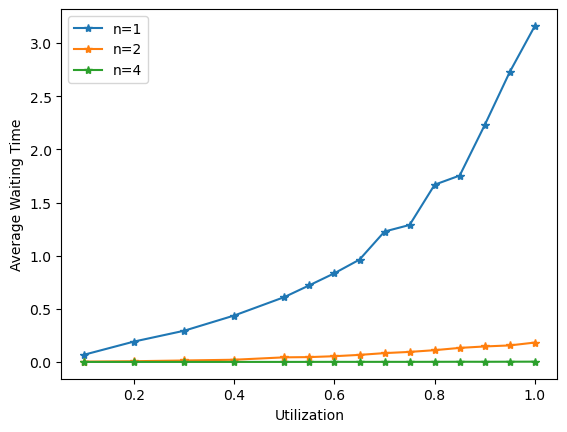

In [142]:
plt.plot(RHO, est_mean_MLn1, "*-", label = "n=1")
plt.plot(RHO, est_mean_MLn2, "*-", label = "n=2")
plt.plot(RHO, est_mean_MLn4, "*-", label = "n=4")
plt.legend()
plt.xlabel("Utilization", fontsize = 10)
plt.ylabel("Average Waiting Time", fontsize= 10)
plt.savefig("W_Vs_Rho_MLn.jpeg")
plt.savefig("W_Vs_Rho_MLn.svg")

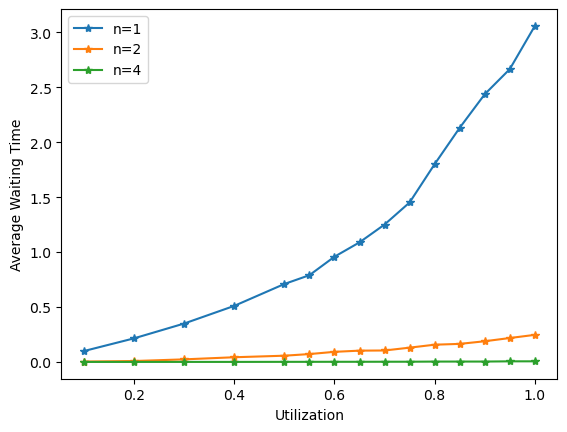

In [143]:
plt.plot(RHO, est_mean_SJF_1, "*-", label = "n=1")
plt.plot(RHO, est_mean_SJF_2, "*-", label = "n=2")
plt.plot(RHO, est_mean_SJF_4, "*-", label = "n=4")
plt.legend()
plt.xlabel("Utilization", fontsize = 10)
plt.ylabel("Average Waiting Time", fontsize= 10)
plt.savefig("W_Vs_Rho_SJF.jpeg")
plt.savefig("W_Vs_Rho_SJF.svg")

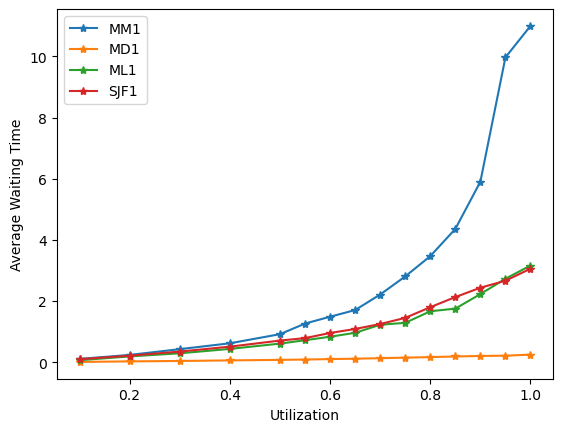

In [144]:
plt.plot(RHO, est_mean_MMn1, "*-", label = "MM1")
plt.plot(RHO, est_mean_MDn1, "*-", label = "MD1")
plt.plot(RHO, est_mean_MLn1, "*-", label = "ML1")
plt.plot(RHO, est_mean_SJF_1, "*-", label = "SJF1")
plt.legend()
plt.xlabel("Utilization", fontsize = 10)
plt.ylabel("Average Waiting Time", fontsize= 10)
plt.savefig("W_Vs_Rho_n1.jpeg")
plt.savefig("W_Vs_Rho_n1.svg")

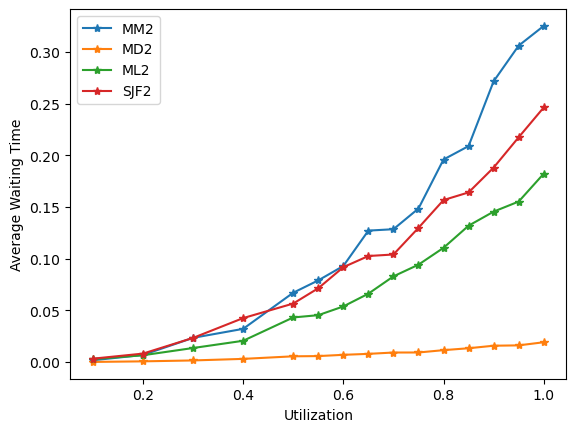

In [145]:
plt.plot(RHO, est_mean_MMn2, "*-", label = "MM2")
plt.plot(RHO, est_mean_MDn2, "*-", label = "MD2")
plt.plot(RHO, est_mean_MLn2, "*-", label = "ML2")
plt.plot(RHO, est_mean_SJF_2, "*-", label = "SJF2")
plt.legend()
plt.xlabel("Utilization", fontsize = 10)
plt.ylabel("Average Waiting Time", fontsize= 10)
plt.savefig("W_Vs_Rho_n2.jpeg")
plt.savefig("W_Vs_Rho_n2.svg")

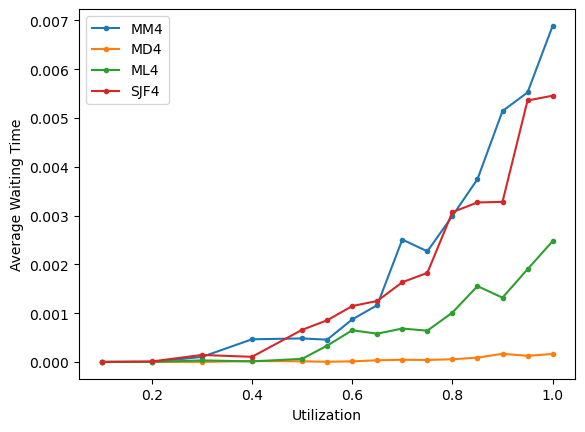

In [146]:
plt.plot(RHO, est_mean_MMn4, ".-", label = "MM4")
plt.plot(RHO, est_mean_MDn4, ".-", label = "MD4")
plt.plot(RHO, est_mean_MLn4, ".-", label = "ML4")
plt.plot(RHO, est_mean_SJF_4, ".-", label = "SJF4")
plt.legend()
plt.xlabel("Utilization", fontsize = 10)
plt.ylabel("Average Waiting Time", fontsize= 10)
plt.savefig("W_Vs_Rho_n4.jpeg")
plt.savefig("W_Vs_Rho_n4.svg")

### Analysis of waiting time Vs Simulation Duration

In [147]:
est_mean_20, est_sojourn_20 = estimate_waiting_times("MMn", RHO, 1, 20)
est_mean_50, est_sojourn_50 = estimate_waiting_times("MMn", RHO, 1, 50)
est_mean_100, est_sojourn_100 = estimate_waiting_times("MMn", RHO, 1, 100)
est_mean_200, est_sojourn_200 = estimate_waiting_times("MMn", RHO, 1, 200)
est_mean_500, est_sojourn_500 = estimate_waiting_times("MMn", RHO, 1, 500)
est_mean_1000, est_sojourn_1000 = estimate_waiting_times("MMn", RHO, 1, 1000)

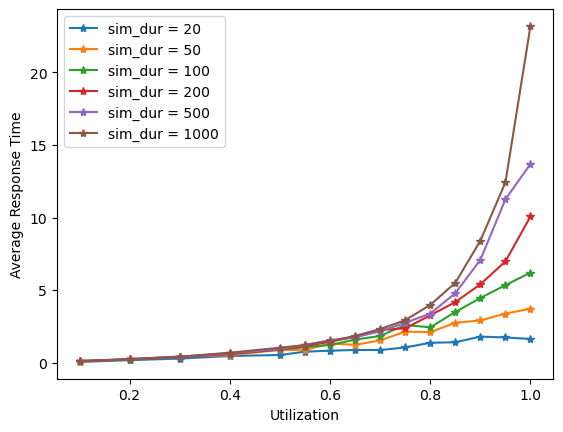

In [148]:
plt.plot(RHO, est_mean_20, "*-", label="sim_dur = 20")
plt.plot( RHO, est_mean_50, "*-", label="sim_dur = 50")
plt.plot(RHO, est_mean_100, "*-", label="sim_dur = 100")
plt.plot(RHO, est_mean_200, "*-", label="sim_dur = 200")
plt.plot(RHO, est_mean_500, "*-", label="sim_dur = 500")
plt.plot(RHO, est_mean_1000, "*-", label="sim_dur = 1000")
plt.legend()
plt.xlabel("Utilization", fontsize=10)
plt.ylabel("Average Response Time", fontsize=10)
plt.savefig("SIM_Duration_vs_Rho_MM1.svg")
plt.savefig("SIM_Duration_vs_Rho_MM1.jpeg")

In [149]:
est_mean_20_2, est_sojourn_20_2 = estimate_waiting_times("MMn", RHO, 2, 20)
est_mean_50_2, est_sojourn_50_2 = estimate_waiting_times("MMn", RHO, 2, 50)
est_mean_100_2, est_sojourn_100_2 = estimate_waiting_times("MMn", RHO, 2, 100)
est_mean_200_2, est_sojourn_200_2 = estimate_waiting_times("MMn", RHO, 2, 200)
est_mean_500_2, est_sojourn_500_2 = estimate_waiting_times("MMn", RHO, 2, 500)
est_mean_1000_2, est_sojourn_1000_2 = estimate_waiting_times("MMn", RHO, 2, 1000)

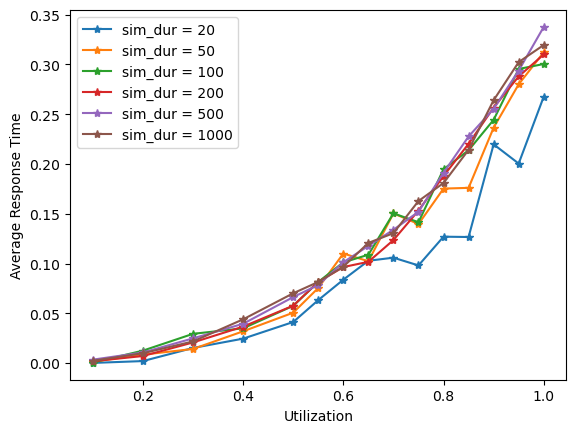

In [150]:
plt.plot(RHO, est_mean_20_2, "*-", label="sim_dur = 20")
plt.plot(RHO, est_mean_50_2, "*-", label="sim_dur = 50")
plt.plot(RHO, est_mean_100_2, "*-", label="sim_dur = 100")
plt.plot(RHO, est_mean_200_2, "*-", label="sim_dur = 200")
plt.plot(RHO, est_mean_500_2, "*-", label="sim_dur = 500")
plt.plot(RHO, est_mean_1000_2, "*-", label="sim_dur = 1000")
plt.legend()
plt.xlabel("Utilization", fontsize=10)
plt.ylabel("Average Response Time", fontsize=10)
plt.savefig("SIM_Duration_vs_Rho_MM2.svg")
plt.savefig("SIM_Duration_vs_Rho_MM2.jpeg")

In [151]:
est_mean_20_4, est_sojourn_20_4 = estimate_waiting_times("MMn", RHO, 4, 20)
est_mean_50_4, est_sojourn_50_4 = estimate_waiting_times("MMn", RHO, 4, 50)
est_mean_100_4, est_sojourn_100_4 = estimate_waiting_times("MMn", RHO, 4, 100)
est_mean_200_4, est_sojourn_200_4 = estimate_waiting_times("MMn", RHO, 4, 200)
est_mean_500_4, est_sojourn_500_4 = estimate_waiting_times("MMn", RHO, 4, 500)
est_mean_1000_4, est_sojourn_1000_4 = estimate_waiting_times("MMn", RHO, 4, 1000)

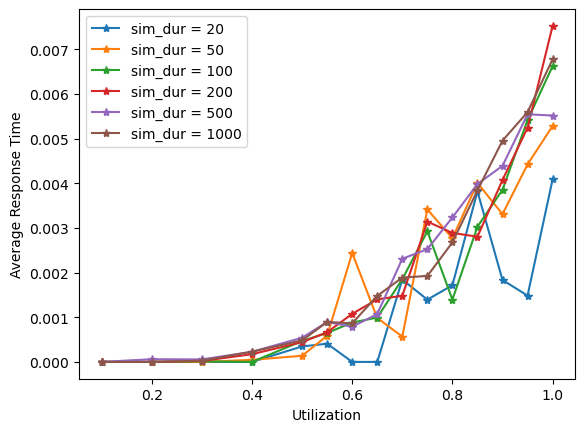

In [152]:
plt.plot(RHO, est_mean_20_4, "*-", label="sim_dur = 20")
plt.plot(RHO, est_mean_50_4, "*-", label="sim_dur = 50")
plt.plot(RHO, est_mean_100_4, "*-", label="sim_dur = 100")
plt.plot(RHO, est_mean_200_4, "*-", label="sim_dur = 200")
plt.plot(RHO, est_mean_500_4, "*-", label="sim_dur = 500")
plt.plot(RHO, est_mean_1000_4, "*-", label="sim_dur = 1000")
plt.legend()
plt.xlabel("Utilization", fontsize=10)
plt.ylabel("Average Response Time", fontsize=10)
plt.savefig("SIM_Duration_vs_Rho_MM4.svg")
plt.savefig("SIM_Duration_vs_Rho_MM4.jpeg")

### Statistical Significance - T-test

In [153]:
#Null hypothesis: The mean queueing time for n=1 < n=2 

def test_estimate_waiting_times(type_queue, RHO, n):

    global_mean_queue_run = []
    global_sj = []
    
    for rho in RHO:
        g.arrival_rate = 1 *rho
        g.service_rate = 1
        g.number_of_servers = n
        g.number_of_runs = 500
        g.sim_duration = 100


        temp_mean_queue_run = []
        temp_sj = []
        temp_service = []
        for run in range(g.number_of_runs):
            queue_model = Queue(run, type_queue)
            queue_model.run()
            temp_mean_queue_run.append(queue_model.mean_queue_time)
            temp_sj.append(queue_model.mean_sojourn_time)
        
        global_mean_queue_run.append(np.array(temp_mean_queue_run))
        global_sj.append(np.array(temp_sj))
    
    return np.array(global_mean_queue_run), np.array(global_sj)

In [154]:
tem_q_time, temp_sj_time = test_estimate_waiting_times("MMn", RHO, 1)
tem_q_time2, temp_sj_time2 = test_estimate_waiting_times("MMn", RHO, 2)
tem_q_time4, temp_sj_time4= test_estimate_waiting_times("MMn", RHO, 4) 

In [155]:
# Save as pickle
import pickle

with open("MMn_1_server.pkl", "wb") as f:
    pickle.dump(tem_q_time, f)

with open("MMn_2_server.pkl", "wb") as f:
    pickle.dump(tem_q_time2, f)
    
with open("MMn_4_server.pkl", "wb") as f:
    pickle.dump(tem_q_time4, f)
    

In [156]:
import pickle
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numba
from tqdm import tqdm


@numba.jit(nopython=True)
def bootstrap(data, replacement, num_samples):
    """Returns bootstrap sample from data."""
    idx = np.random.choice(len(data), (num_samples), replace=replacement)
    return data[idx]


def num_sim_for_statistical_significance(tem_time1, tem_time2):

    num_sim_for_rho = np.zeros((len(tem_time1), 1000))

    for i in tqdm(range(len(tem_time1))):  # For each rho

        for j in range(1000):
            rejected = False
            count = 0
            while not rejected:
                count += 1
                values1 = bootstrap(tem_time1[i], True, count).flatten()
                values2 = bootstrap(tem_time2[i], True, count).flatten()

                # ALternative = greater means that waiting time t1 > t2
                t_stat, p_value = stats.ttest_ind(
                    values1, values2, alternative="greater")

                if p_value < 0.05:
                    num_sim_for_rho[i, j] = count
                    rejected = True
    return num_sim_for_rho


# Load the pickle
with open("MMn_1_server.pkl", "rb") as f:
    queue_time1 = pickle.load(f)

with open("MMn_2_server.pkl", "rb") as f:
    queue_time2 = pickle.load(f)

with open("MMn_4_server.pkl", "rb") as f:
    queue_time4 = pickle.load(f)



In [157]:
rejection_numbers_per_rho = num_sim_for_statistical_significance(queue_time1, queue_time2)

  0%|          | 0/15 [00:00<?, ?it/s]/Users/divyagajera/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:7030: RuntimeWarning: invalid value encountered in scalar divide
  svar = ((n1 - 1) * v1 + (n2 - 1) * v2) / df
/Users/divyagajera/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
100%|██████████| 15/15 [00:06<00:00,  2.18it/s]


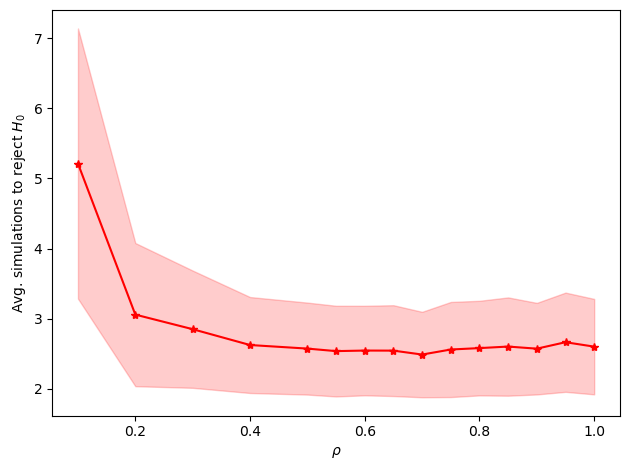

In [158]:
# Plot the rejection numbers per rho
# Take mean and fill between std.
means = [np.mean(x) for x in rejection_numbers_per_rho]
std = [np.std(x) for x in rejection_numbers_per_rho]

plt.plot(RHO, means, "*-r")
plt.fill_between(RHO, np.array(means)-np.array(std),
                 np.array(means)+np.array(std), alpha=0.2, color="r")
plt.xlabel(r"$\rho$", fontsize=10)
plt.ylabel(r"Avg. simulations to reject $H_0$", fontsize=10)
plt.tight_layout()
plt.savefig("bootstrap.png")
plt.savefig("bootstrap.svg")

plt.show()

In [159]:
rejection_numbers_per_rho_2 = num_sim_for_statistical_significance(queue_time1, queue_time4)

100%|██████████| 15/15 [00:06<00:00,  2.25it/s]


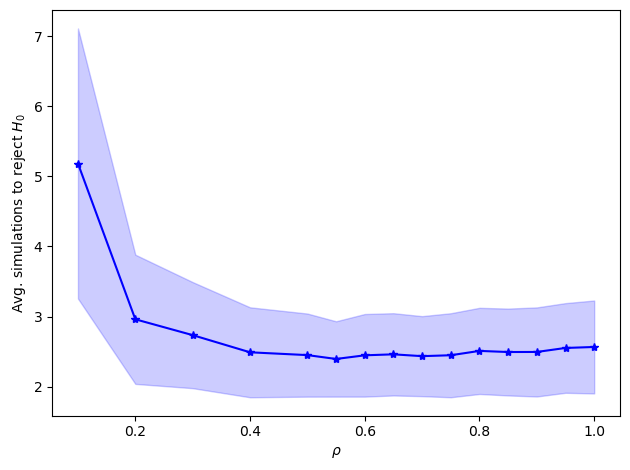

In [160]:

# Plot the rejection numbers per rho
# Take mean and fill between std.
means = [np.mean(x) for x in rejection_numbers_per_rho_2]
std = [np.std(x) for x in rejection_numbers_per_rho_2]

plt.plot(RHO, means, "*-b")
plt.fill_between(RHO, np.array(means)-np.array(std),
                 np.array(means)+np.array(std), alpha=0.2,color="b" )
plt.xlabel(r"$\rho$", fontsize=10)
plt.ylabel(r"Avg. simulations to reject $H_0$", fontsize=10)
plt.tight_layout()
plt.savefig("bootstrap14.png")
plt.savefig("bootstrap14.svg")
plt.show()